In [1]:
import pandas as pd
import numpy as np
# from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import IterativeImputer

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import shap

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import xgboost as xgb

from longitudinal.settings.constants import DATA_PATH

gen1_train = pd.read_csv(DATA_PATH + "gen1_train_comp_final.csv")  # parent data (training)
gen2_train = pd.read_csv(DATA_PATH + "gen2_train_comp_final.csv")  # child data (training)

gen1_test = pd.read_csv(DATA_PATH + "gen1_test_comp_final.csv")    # parent data (test)
gen2_test = pd.read_csv(DATA_PATH + "gen2_test_upto9_comp_final.csv")  # child data, up to age 9

# submission template
submission = pd.read_csv(DATA_PATH + "gen2_test_solution_template.csv")
submission["gen2_id"] = submission["gen2id_age"].str[: 4].astype(float)
submission["age"] = submission["gen2id_age"].str[-2:].astype(float)
submission.head()

,gen2id_age,SHgt_cm,gen2_id,age
0,2831_10,150,2831.0,10.0
1,2831_11,150,2831.0,11.0
2,2831_12,150,2831.0,12.0
3,2831_13,150,2831.0,13.0
4,2831_14,150,2831.0,14.0


In [2]:
gen1_train.shape, gen2_train.shape, gen1_test.shape, gen2_test.shape

((3636, 4), (4224, 7), (2232, 4), (1232, 7))

In [3]:
# gen1_test = gen1_test[gen1_test[""]]

In [4]:
def preprocess(gen1_train, gen2_train, gen1_imputer=None, gen2_imputer=None, test=False):
    
    gen1_train = gen1_train.rename(columns={"age": "AgeGr"})
    gen1_train['sex_assigned_at_birth'] = gen1_train['sex_assigned_at_birth'].map({'M': 1, 'F': 0})
    gen2_train['sex_assigned_at_birth'] = gen2_train['sex_assigned_at_birth'].map({'M': 1, 'F': 0})
    gen2_train['study_parent_sex'] = gen2_train['study_parent_sex'].map({'mother': 1, 'father': 0})

    # if gen1_imputer is None and gen2_imputer is None:
    #     # non_negative_estimator = HistGradientBoostingRegressor(loss="poisson", random_state=0)
    gen1_imputer = IterativeImputer(max_iter=10, random_state=0, min_value=0, initial_strategy="mean")
    gen2_imputer = IterativeImputer(max_iter=10, random_state=0, min_value=0, initial_strategy="mean")
    
    gen1_train_imputed = pd.DataFrame(gen1_imputer.fit_transform(gen1_train), columns=gen1_train.columns)
    gen2_train_imputed = pd.DataFrame(gen2_imputer.fit_transform(gen2_train), columns=gen2_train.columns)

    gen1_temp = gen1_train_imputed.pivot(index = "gen1_id", columns="AgeGr", values="SHgt_cm").reset_index()

    gen1_temp.columns = [str(col) for col in gen1_temp.columns]
    gen2_train_imputed.columns = [str(col) for col in gen2_train_imputed.columns]

    gen2_train_merged = gen2_train_imputed.merge(
        gen1_temp,
        how="left",
        left_on='study_parent_id_new', 
        right_on='gen1_id',            
        suffixes=('_child', '_parent')
    )
    
    gen2_train_merged_imputer = IterativeImputer(max_iter=10, random_state=0, min_value=0, initial_strategy="mean")
    gen2_train_merged = pd.DataFrame(gen2_train_merged_imputer.fit_transform(gen2_train_merged), columns=gen2_train_merged.columns)

    # Ensure sorting before creating lags
    gen2_train_merged = gen2_train_merged.sort_values(by=["gen2_id", "AgeGr"])
    gen2_train_merged.drop_duplicates(inplace=True)

    # Create gender interaction feature
    gen2_train_merged["gender_interaction"] = (
        gen2_train_merged["sex_assigned_at_birth"] * gen2_train_merged["study_parent_sex"]
    )

    # Compute differences between child's height and parent's height at different ages
    for age in [0.25, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
        gen2_train_merged[f"{age}_diff"] = gen2_train_merged["SHgt_cm"] - gen2_train_merged[str(age)]

    # Generate the last 9 height lags per child
    for lag in range(1, 10):
        gen2_train_merged[f"height_lag_{lag}"] = gen2_train_merged.groupby("gen2_id")["SHgt_cm"].shift(lag)

    # Define target variable
    target = "SHgt_cm"
    y = gen2_train_merged[target]
    X = gen2_train_merged.drop(columns=[target])

    if test:
        return gen2_train_merged
    return X, y, gen1_imputer, gen2_imputer


In [5]:
X, y, gen1_imputer, gen2_imputer = preprocess(gen1_train, gen2_train)

/Users/walkerhughes/Documents/MSDS/longitudinal/.venv/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [6]:
test = preprocess(gen1_test, gen2_test, gen1_imputer, gen2_imputer, test=True)

/Users/walkerhughes/Documents/MSDS/longitudinal/.venv/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.head()

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,Wgt_kg,gen1_id,0.1,0.25,0.5,...,9.0_diff,height_lag_1,height_lag_2,height_lag_3,height_lag_4,height_lag_5,height_lag_6,height_lag_7,height_lag_8,height_lag_9
180,2815.0,0.0,1.0,474.0,1.00,0.000000,474.0,51.798074,59.278234,64.281117,...,-50.329062,69.596771,66.190521,60.527746,51.031376,NaN,NaN,NaN,NaN,NaN
3015,2590.0,0.0,1.0,420.0,0.25,0.000000,420.0,51.906949,60.112879,66.540105,...,-72.235748,73.959236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2379,2632.0,1.0,0.0,344.0,0.75,0.000000,344.0,56.005683,64.922836,69.081746,...,-57.230936,74.408736,64.199136,57.639485,NaN,NaN,NaN,NaN,NaN,NaN
2593,2619.0,0.0,0.0,713.0,15.00,57.447287,713.0,55.491800,62.468009,70.846442,...,26.835773,162.418674,153.621193,148.748447,142.822506,137.626116,134.652455,127.911713,122.840316,118.112220
296,2805.0,1.0,1.0,370.0,6.00,12.844804,370.0,56.040541,62.560859,70.338540,...,-28.983868,111.312962,105.264358,98.850010,88.555088,85.088723,78.208234,73.827788,68.119453,62.000444


In [9]:
y_train

180      73.695897
3015     62.639139
2379     80.063594
2593    166.402419
296     110.963524
           ...    
782     130.143318
3744     80.749299
1134    119.841999
450     122.319909
3346     68.911838
Name: SHgt_cm, Length: 3379, dtype: float64

In [9]:
test = test[test["gen2_id"].isin(submission["gen2_id"].unique())]
test.head()

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg,gen1_id,0.1,0.25,...,9.0_diff,height_lag_1,height_lag_2,height_lag_3,height_lag_4,height_lag_5,height_lag_6,height_lag_7,height_lag_8,height_lag_9
1218,2332.0,1.0,1.0,274.0,0.10,67.460127,0.000000,274.0,52.099079,58.871339,...,-68.830853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1219,2332.0,1.0,1.0,274.0,0.25,60.904589,0.000000,274.0,51.960908,59.022173,...,-75.341159,67.460127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1220,2332.0,1.0,1.0,274.0,0.50,65.427869,0.000000,274.0,52.082825,58.966465,...,-70.786947,60.904589,67.460127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1221,2332.0,1.0,1.0,274.0,0.75,71.735214,0.696426,274.0,52.192669,58.881363,...,-64.483638,65.427869,60.904589,67.460127,NaN,NaN,NaN,NaN,NaN,NaN
1222,2332.0,1.0,1.0,274.0,1.00,74.239243,1.861620,274.0,52.180303,58.875948,...,-61.992784,71.735214,65.427869,60.904589,67.460127,NaN,NaN,NaN,NaN,NaN


In [10]:
test["gen2_id"].nunique()

82

In [11]:
test = test[test["gen2_id"].isin(submission["gen2_id"].unique())]
test.head()

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg,gen1_id,0.1,0.25,...,9.0_diff,height_lag_1,height_lag_2,height_lag_3,height_lag_4,height_lag_5,height_lag_6,height_lag_7,height_lag_8,height_lag_9
1218,2332.0,1.0,1.0,274.0,0.10,67.460127,0.000000,274.0,52.099079,58.871339,...,-68.830853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1219,2332.0,1.0,1.0,274.0,0.25,60.904589,0.000000,274.0,51.960908,59.022173,...,-75.341159,67.460127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1220,2332.0,1.0,1.0,274.0,0.50,65.427869,0.000000,274.0,52.082825,58.966465,...,-70.786947,60.904589,67.460127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1221,2332.0,1.0,1.0,274.0,0.75,71.735214,0.696426,274.0,52.192669,58.881363,...,-64.483638,65.427869,60.904589,67.460127,NaN,NaN,NaN,NaN,NaN,NaN
1222,2332.0,1.0,1.0,274.0,1.00,74.239243,1.861620,274.0,52.180303,58.875948,...,-61.992784,71.735214,65.427869,60.904589,67.460127,NaN,NaN,NaN,NaN,NaN


In [12]:
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of boosting rounds
    "learning_rate": [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    "max_depth": [3, 5, 7, 9],  # Maximum depth of trees
    "subsample": [0.6, 0.8, 1.0],  # Fraction of samples used per tree
    "colsample_bytree": [0.6, 0.8, 1.0],  # Fraction of features used per tree
    "gamma": [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required to make a split
    "reg_alpha": [0, 0.01, 0.1, 1.0],  # L1 regularization
    "reg_lambda": [1.0, 2.0, 5.0]  # L2 regularization
}

model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=30, 
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)
print("Best MAE:", -random_search.best_score_)

Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 1.0, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
Best MAE: 0.5552669547591506


In [13]:
model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **random_search.best_params_)
model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test MAE: {mae:.2f} cm")
print(f"Test RMSE: {rmse:.2f} cm")

Test MAE: 0.52 cm
Test RMSE: 0.72 cm


In [14]:
y_test = test["SHgt_cm"]
x_test = test.drop(columns=["SHgt_cm"])

y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test MAE: {mae:.2f} cm")
print(f"Test RMSE: {rmse:.2f} cm")

Test MAE: 1.66 cm
Test RMSE: 2.87 cm


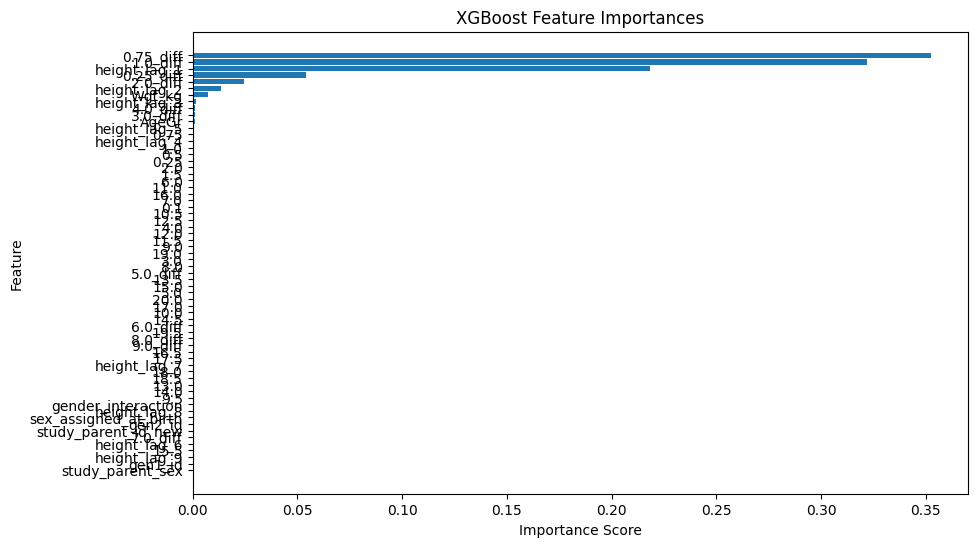

In [15]:
feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)
importance_df["Feature"] = importance_df["Feature"].astype(str)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importances")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

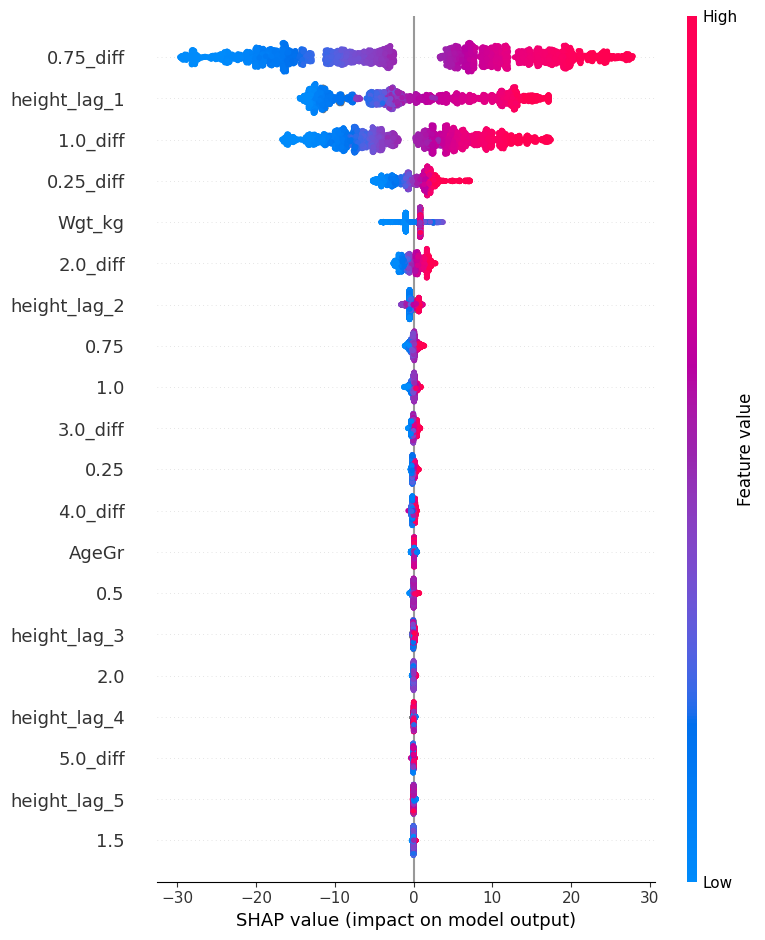

In [16]:
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.summary_plot(shap_values, X, feature_names=X.columns)

## Inference

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
TEMP = x_test[x_test["AgeGr"] == 9.0]
TEMP

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,Wgt_kg,gen1_id,0.1,0.25,0.5,...,9.0_diff,height_lag_1,height_lag_2,height_lag_3,height_lag_4,height_lag_5,height_lag_6,height_lag_7,height_lag_8,height_lag_9
1231,2332.0,1.0,1.0,274.0,9.0,35.021449,274.0,51.475144,59.209029,68.332534,...,-9.312898,120.052957,116.386523,109.936726,103.870670,97.413918,91.019129,82.108449,79.359604,74.239243
1217,2503.0,0.0,0.0,332.0,9.0,34.682325,332.0,54.396011,65.467128,68.777631,...,10.797440,135.072529,127.240471,122.531539,115.000674,108.233606,100.187839,89.375824,74.801434,76.894700
1203,2504.0,0.0,0.0,623.0,9.0,30.887921,623.0,55.405680,62.317808,69.192296,...,-1.528348,123.692319,116.679299,112.435157,106.850400,102.629709,95.011010,86.669085,81.734484,74.700206
1189,2506.0,0.0,0.0,576.0,9.0,31.977254,576.0,58.508684,64.940758,73.205793,...,-3.538238,134.341149,128.942749,121.629899,115.475808,109.749886,102.487697,92.439675,83.878779,78.648926
1175,2508.0,0.0,1.0,333.0,9.0,32.631151,333.0,52.572317,60.861702,67.760189,...,6.237467,137.364845,129.582019,124.002188,115.937959,107.352638,97.965989,88.858038,84.128667,77.159045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2820.0,1.0,1.0,389.0,9.0,26.969484,389.0,51.875506,59.627795,66.082873,...,3.011764,123.560549,118.959285,115.544696,110.436771,103.852288,97.117508,87.275235,82.669166,75.638018
55,2821.0,0.0,1.0,600.0,9.0,46.338635,600.0,54.257544,58.576816,64.260274,...,12.697394,136.435080,129.765068,122.141105,115.683180,108.813557,98.884833,87.745339,82.943933,76.296288
41,2822.0,1.0,1.0,521.0,9.0,30.309771,521.0,55.714156,61.569324,68.599613,...,0.642736,131.470996,126.165706,120.131471,114.336429,107.812102,100.286270,90.457748,86.161394,77.849343
27,2823.0,1.0,1.0,665.0,9.0,26.320472,665.0,56.550000,61.090817,68.233684,...,-0.942106,125.967279,121.275564,116.515023,111.370950,107.008163,99.601210,91.161540,86.198430,80.226826


In [19]:
preds = dict()
TEMP = x_test[x_test["AgeGr"] == 9.0].copy()

for age in range(10, 19):
    p = model.predict(TEMP)
    preds[age] = p

    # Shift all lags back by one position
    TEMP.iloc[:, -8:] = TEMP.iloc[:, -9:-1]  

    # Update Age
    TEMP["AgeGr"] = age

    # Ensure first lag correctly stores the new prediction
    TEMP.iloc[:, -9] = p  

In [20]:
TEMP

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,Wgt_kg,gen1_id,0.1,0.25,0.5,...,9.0_diff,height_lag_1,height_lag_2,height_lag_3,height_lag_4,height_lag_5,height_lag_6,height_lag_7,height_lag_8,height_lag_9
1231,2332.0,1.0,1.0,274.0,18,35.021449,274.0,51.475144,59.209029,68.332534,...,-9.312898,133.210007,133.210007,132.919174,132.775131,132.269547,131.549774,131.297424,129.354477,126.771515
1217,2503.0,0.0,0.0,332.0,18,34.682325,332.0,54.396011,65.467128,68.777631,...,10.797440,150.646454,150.643616,150.718826,150.740372,150.887207,150.203430,149.547150,147.425903,143.943115
1203,2504.0,0.0,0.0,623.0,18,30.887921,623.0,55.405680,62.317808,69.192296,...,-1.528348,135.032272,135.032272,135.032272,135.032257,135.032013,134.765656,134.059464,132.077911,128.790726
1189,2506.0,0.0,0.0,576.0,18,31.977254,576.0,58.508684,64.940758,73.205793,...,-3.538238,143.664230,143.664230,143.666580,143.709106,142.611862,141.673889,141.491730,140.692535,139.648468
1175,2508.0,0.0,1.0,333.0,18,32.631151,333.0,52.572317,60.861702,67.760189,...,6.237467,146.926712,146.926712,146.932343,146.918365,146.915543,146.911774,146.822784,145.861084,143.130249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2820.0,1.0,1.0,389.0,18,26.969484,389.0,51.875506,59.627795,66.082873,...,3.011764,134.373856,134.373856,134.373856,134.373856,134.379410,134.402603,133.969879,132.748245,129.527771
55,2821.0,0.0,1.0,600.0,18,46.338635,600.0,54.257544,58.576816,64.260274,...,12.697394,148.727097,148.570572,148.757919,148.590408,148.774475,148.486374,147.667175,146.239548,142.221054
41,2822.0,1.0,1.0,521.0,18,30.309771,521.0,55.714156,61.569324,68.599613,...,0.642736,141.228455,141.228210,141.226013,141.243408,140.890350,139.896545,139.455078,138.831299,136.999359
27,2823.0,1.0,1.0,665.0,18,26.320472,665.0,56.550000,61.090817,68.233684,...,-0.942106,135.984467,135.986328,135.986328,135.984741,135.986313,135.781387,135.295364,134.059143,131.371307


In [21]:
TEMP["gen2_id"]

1231    2332.0
1217    2503.0
1203    2504.0
1189    2506.0
1175    2508.0
         ...  
69      2820.0
55      2821.0
41      2822.0
27      2823.0
13      2831.0
Name: gen2_id, Length: 82, dtype: float64

In [22]:
preds = pd.DataFrame(preds)
preds["id"] = TEMP["gen2_id"].values.astype(int)
preds

,10,11,12,13,14,15,16,17,18,id
0,126.771515,129.354477,131.297424,131.549774,132.269547,132.775131,132.919174,133.210007,133.210007,2332
1,143.943115,147.425903,149.547150,150.203430,150.887207,150.740372,150.718826,150.643616,150.646454,2503
2,128.790726,132.077911,134.059464,134.765656,135.032013,135.032257,135.032272,135.032272,135.032272,2504
3,139.648468,140.692535,141.491730,141.673889,142.611862,143.709106,143.666580,143.664230,143.664230,2506
4,143.130249,145.861084,146.822784,146.911774,146.915543,146.918365,146.932343,146.926712,146.926712,2508
...,...,...,...,...,...,...,...,...,...,...
77,129.527771,132.748245,133.969879,134.402603,134.379410,134.373856,134.373856,134.373856,134.373856,2820
78,142.221054,146.239548,147.667175,148.486374,148.774475,148.590408,148.757919,148.570572,148.727097,2821
79,136.999359,138.831299,139.455078,139.896545,140.890350,141.243408,141.226013,141.228210,141.228455,2822
80,131.371307,134.059143,135.295364,135.781387,135.986313,135.984741,135.986328,135.986328,135.984467,2823


In [23]:
gen2_test[["gen2_id", "sex_assigned_at_birth", "study_parent_sex"]].drop_duplicates()

,gen2_id,sex_assigned_at_birth,study_parent_sex
0,2831,0,1
14,2823,1,1
28,2822,1,1
42,2821,0,1
56,2820,1,1
...,...,...,...
1162,2508,0,1
1176,2506,0,0
1190,2504,0,0
1204,2503,0,0


In [24]:
gen2_test["gen2_id"].nunique()

88

In [25]:
# Melt preds dataframe
preds_melted = preds.melt(id_vars=["id"], var_name="age", value_name="SHgt_cm")

# Convert age column to string and concatenate with gen2_id
preds_melted["gen2id_age"] = preds_melted["id"].astype(str) + "_" + preds_melted["age"].astype(str)

# Select only required columns
submission_preds = preds_melted[["gen2id_age", "SHgt_cm"]]

# Sort to match submission order (if necessary)
submission_preds = submission_preds.sort_values(by=["gen2id_age"]).reset_index(drop=True)
# submission_preds["gen2_id"] = submission_preds["gen2id_age"].str[: 4].astype(float)
# submission_preds["age"] = submission_preds["gen2id_age"].str[-2:].astype(float)
submission_preds.sort_values(by=["gen2id_age"])

,gen2id_age,SHgt_cm
0,2332_10,126.771515
1,2332_11,129.354477
2,2332_12,131.297424
3,2332_13,131.549774
4,2332_14,132.269547
...,...,...
733,2831_14,136.030838
734,2831_15,136.035797
735,2831_16,136.037384
736,2831_17,136.035522


In [26]:
# submission.sort_values(by=["gen2id_age"]).tail(20)

In [27]:
submission_preds = submission.merge(submission_preds, on=["gen2id_age"], how="inner").drop(columns=["SHgt_cm_x", "gen2_id", "age"]).rename(columns={"SHgt_cm_y": "SHgt_cm"})

In [28]:
submission.shape, submission_preds.shape

((589, 4), (589, 2))

In [32]:
submission_preds.to_csv("wh_xgboost_submission_2.csv", index = False)

In [30]:
set(submission_preds["gen2id_age"].values) - set(submission["gen2id_age"].values)

set()

In [31]:
submission

,gen2id_age,SHgt_cm,gen2_id,age
0,2831_10,150,2831.0,10.0
1,2831_11,150,2831.0,11.0
2,2831_12,150,2831.0,12.0
3,2831_13,150,2831.0,13.0
4,2831_14,150,2831.0,14.0
...,...,...,...,...
584,2332_11,150,2332.0,11.0
585,2332_12,150,2332.0,12.0
586,2332_13,150,2332.0,13.0
587,2332_14,150,2332.0,14.0
